## Imports

In [1]:
%pip install tensorflow
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings


## Data Analysis

In [2]:

# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 

# data (as pandas dataframes) 
data_features = predict_students_dropout_and_academic_success.data.features 
data_targets = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 

# variable information 
print(predict_students_dropout_and_academic_success.variables) 


{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

C:\Users\Ibrah\AppData\Local\Temp\ipykernel_35060\3356247271.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=["Dropout", "Enrolled", "Graduate"], y=data_pie.values, palette="pastel")


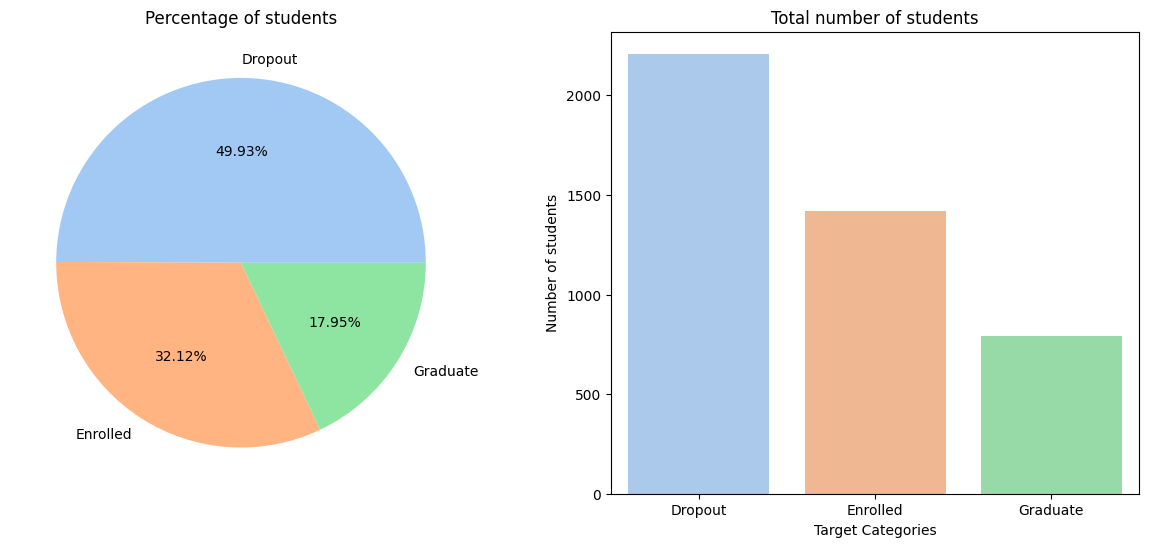

In [3]:
data_pie = data_targets['Target'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.pie(data_pie,  autopct="%.2f%%", labels=["Dropout", "Enrolled", "Graduate"],colors=sns.color_palette('pastel'))
ax1.set_title('Percentage of students')

ax2 = sns.barplot(x=["Dropout", "Enrolled", "Graduate"], y=data_pie.values, palette="pastel")
ax2.set(xlabel='Target Categories', ylabel='Number of students')
ax2.set_title('Total number of students')

plt.show()

### Univariate Outlier Detection

In [4]:

numeric_cols = data_features.select_dtypes(include=np.number).columns

# Z-score method
z_scores = data_features[numeric_cols].apply(zscore)
outliers_z = (np.abs(z_scores) > 3).sum().sort_values(ascending=False)
print("Outliers (Z-score method):\n", outliers_z)

# IQR method
Q1 = data_features[numeric_cols].quantile(0.25)
Q3 = data_features[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((data_features[numeric_cols] < (Q1 - 1.5 * IQR)) |
                (data_features[numeric_cols] > (Q3 + 1.5 * IQR))).sum().sort_values(ascending=False)
print("Outliers (IQR method):\n", outliers_iqr)


Outliers (Z-score method):
 Previous qualification                            308
Course                                            227
Father's occupation                               177
Curricular units 1st sem (credited)               149
Application order                                 138
Marital Status                                    126
Mother's occupation                               112
International                                     110
Curricular units 2nd sem (credited)               110
Curricular units 1st sem (enrolled)               106
Age at enrollment                                 101
Curricular units 2nd sem (without evaluations)     94
Curricular units 2nd sem (enrolled)                82
Nacionality                                        74
Curricular units 1st sem (without evaluations)     62
Curricular units 1st sem (approved)                61
Curricular units 1st sem (evaluations)             60
Educational special needs                          51


### Multivariate Outlier Detection

In [5]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_pred = iso_forest.fit_predict(data_features[numeric_cols])
print("Outlier counts:", pd.Series(outlier_pred).value_counts())


Outlier counts:  1    4379
-1      45
Name: count, dtype: int64


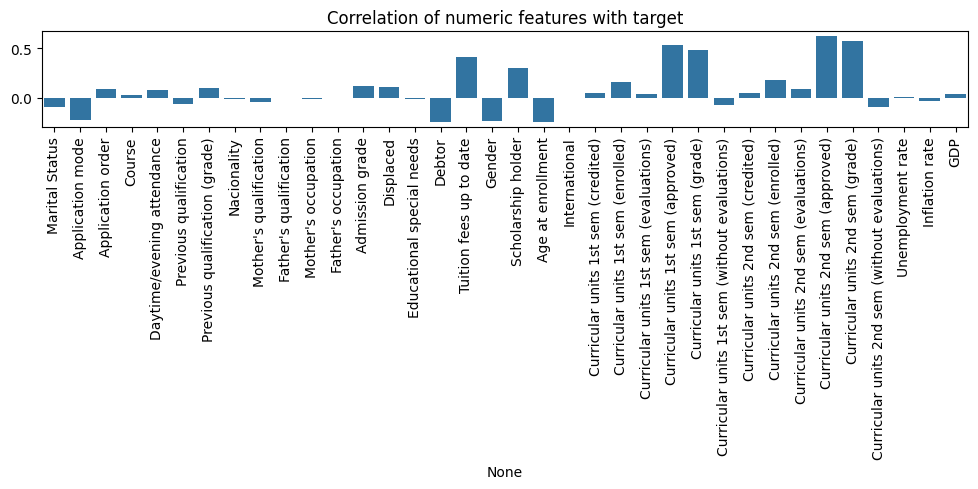

In [6]:
# Correlation with target for numeric features
corr_matrix = data_features[numeric_cols].corrwith(data_targets['Target'].astype('category').cat.codes)
plt.figure(figsize=(10, 5))
sns.barplot(x=corr_matrix.index, y=corr_matrix.values)
plt.xticks(rotation=90)
plt.title("Correlation of numeric features with target")
plt.tight_layout()
plt.show()


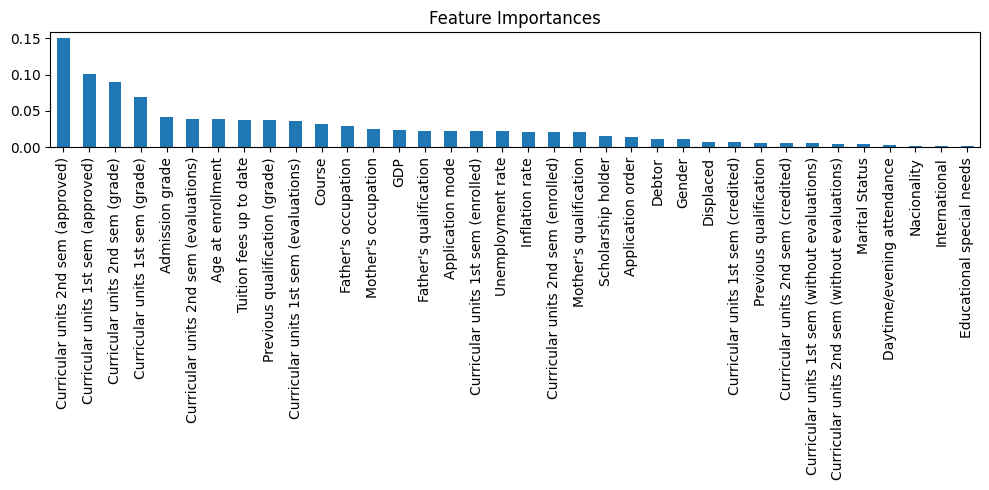

In [7]:
rf = RandomForestClassifier()
rf.fit(data_features.select_dtypes(include=np.number), data_targets['Target'])

importances = pd.Series(rf.feature_importances_, index=data_features.select_dtypes(include=np.number).columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title='Feature Importances')
plt.tight_layout()
plt.show()


In [8]:
threshold = 0.01 
important_features = importances[importances > threshold].index.tolist()

# Filter dataset
X_reduced = data_features[important_features]


## Traditional Methods

In [9]:
# Encode target
le_target = LabelEncoder()
y = le_target.fit_transform(data_targets['Target'])  # 1D array
target_labels = le_target.classes_  # for readable report

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_features.select_dtypes(include=np.number), y)

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV to find the best hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X_test)

# Output classification performance
print("Best Hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred, target_names=target_labels))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
              precision    recall  f1-score   support

     Dropout       0.81      0.79      0.80       441
    Enrolled       0.56      0.34      0.42       245
    Graduate       0.79      0.92      0.85       642

    accuracy                           0.77      1328
   macro avg       0.72      0.68      0.69      1328
weighted avg       0.75      0.77      0.76      1328



In [10]:
# Encode target
le_target = LabelEncoder()
y = le_target.fit_transform(data_targets['Target'])
target_labels = le_target.classes_

In [11]:
# Base numeric feature set
X_all = data_features.select_dtypes(include=np.number)

# Store selected features for each method
feature_sets = {}

# 1. SelectKBest
skb = SelectKBest(score_func=f_classif, k=25)
skb.fit(X_all, y)
feature_sets['SelectKBest'] = X_all.columns[skb.get_support()]

# 2. RFE
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=25)
rfe.fit(X_all, y)
feature_sets['RFE'] = X_all.columns[rfe.support_]

# 3. Mutual Information
mi = mutual_info_classif(X_all, y, random_state=42)
mi_series = pd.Series(mi, index=X_all.columns)
feature_sets['MutualInfo'] = mi_series.sort_values(ascending=False).head(25).index

# 4. L1 Logistic Regression
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=2000)
sfm = SelectFromModel(logreg)
sfm.fit(X_all, y)
feature_sets['L1_LogReg'] = X_all.columns[sfm.get_support()]

# GridSearch parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Evaluate each method with GridSearchCV
for method, cols in feature_sets.items():
    print(f"\n=== {method} ===")
    X = data_features[cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Best Hyperparameters:", grid_search.best_params_)
    print(classification_report(y_test, y_pred, target_names=target_labels))



=== SelectKBest ===
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

     Dropout       0.82      0.79      0.80       441
    Enrolled       0.57      0.33      0.41       245
    Graduate       0.78      0.93      0.85       642

    accuracy                           0.77      1328
   macro avg       0.72      0.68      0.69      1328
weighted avg       0.75      0.77      0.75      1328


=== RFE ===
Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

     Dropout       0.82      0.77      0.79       441
    Enrolled       0.58      0.31      0.40       245
    Graduate       0.77      0.94      0.84       642

    accuracy                           0.76      1328
   macro avg       0.72      0.67      0.68      1328
w

In [12]:
warnings.filterwarnings('ignore')

# Encode target
le_target = LabelEncoder()
y = le_target.fit_transform(data_targets['Target'])
target_labels = le_target.classes_

# Base numeric features
X_all = data_features.select_dtypes(include=np.number)

# Feature selection methods
feature_sets = {}

# 1. SelectKBest (ANOVA F-test)
skb = SelectKBest(score_func=f_classif, k=25)
skb.fit(X_all, y)
feature_sets['SelectKBest'] = X_all.columns[skb.get_support()]

# 2. RFE with RandomForest
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=25)
rfe.fit(X_all, y)
feature_sets['RFE'] = X_all.columns[rfe.support_]

# 3. Mutual Information
mi = mutual_info_classif(X_all, y, random_state=42)
mi_series = pd.Series(mi, index=X_all.columns)
feature_sets['MutualInfo'] = mi_series.sort_values(ascending=False).head(25).index

# 4. L1-based Logistic Regression
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=42)
sfm = SelectFromModel(logreg)
sfm.fit(X_all, y)
feature_sets['L1_LogReg'] = X_all.columns[sfm.get_support()]

# Classifiers and hyperparameter grids
models = {
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'bootstrap': [True, False]
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=2000, solver='liblinear'),
        {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0]
        }
    )
}

# Evaluate all combinations
for fs_name, selected_cols in feature_sets.items():
    print(f"\n=== Feature Selection: {fs_name} ===")
    X = data_features[selected_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    for model_name, (model, param_grid) in models.items():
        print(f"\n--- Model: {model_name} ---")
        grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=0)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        
        print("Best Hyperparameters:", grid.best_params_)
        print(classification_report(y_test, y_pred, target_names=target_labels))



=== Feature Selection: SelectKBest ===

--- Model: RandomForest ---
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

     Dropout       0.82      0.79      0.81       441
    Enrolled       0.56      0.33      0.42       245
    Graduate       0.78      0.92      0.84       642

    accuracy                           0.77      1328
   macro avg       0.72      0.68      0.69      1328
weighted avg       0.75      0.77      0.75      1328


--- Model: LogisticRegression ---
Best Hyperparameters: {'C': 1, 'penalty': 'l2'}
              precision    recall  f1-score   support

     Dropout       0.78      0.79      0.79       441
    Enrolled       0.54      0.22      0.32       245
    Graduate       0.77      0.94      0.84       642

    accuracy                           0.76      1328
   macro avg       0.70      0.65      0.65      1328
weighted av

## CNN Methods

In [13]:
# One-hot encode the target for DNN
y_cat = to_categorical(y)

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to build and train a DNN model
def build_and_train_dnn(X_train, X_test, y_train_cat, y_test_cat, input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(y_cat.shape[1], activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train_cat,
              epochs=50,
              batch_size=32,
              validation_split=0.2,
              callbacks=[early_stop],
              verbose=0)
    
    y_pred_cat = model.predict(X_test)
    y_pred = np.argmax(y_pred_cat, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    return y_pred, y_true

# Evaluate DNN on each feature selection method
for fs_name, selected_cols in feature_sets.items():
    print(f"\n=== DNN with Feature Selection: {fs_name} ===")
    
    X = data_features[selected_cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.3, random_state=42)

    y_pred, y_true = build_and_train_dnn(X_train, X_test, y_train, y_test, input_dim=X_train.shape[1])
    
    print(classification_report(y_true, y_pred, target_names=target_labels))



=== DNN with Feature Selection: SelectKBest ===
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

     Dropout       0.84      0.75      0.80       441
    Enrolled       0.51      0.37      0.43       245
    Graduate       0.78      0.91      0.84       642

    accuracy                           0.76      1328
   macro avg       0.71      0.68      0.69      1328
weighted avg       0.75      0.76      0.75      1328


=== DNN with Feature Selection: RFE ===
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

     Dropout       0.86      0.76      0.80       441
    Enrolled       0.53      0.38      0.44       245
    Graduate       0.78      0.93      0.84       642

    accuracy                           0.77      1328
   macro avg       0.72      0.69      0.70      1328
weighted avg       0.76      0.77      0.76      1328


=== DNN with Feature Selection: MutualInfo ===
42/42 ━━━━━━━━━━━━━━━━

In [14]:
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Example data preparation
# Assume you have data_features and target_labels already defined
X = data_features.select_dtypes(include=np.number).values
y_cat = tf.keras.utils.to_categorical(y)

# Split the dataset into training and testing sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.3, random_state=42)

input_dim = X_train.shape[1]

# Define a function to build the DNN model
def build_model(n_units=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_cat.shape[1], activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning manually
param_combinations = [
    {'n_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'n_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'n_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0005},
    {'n_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0005}
]

# List to store results
results = []

# Loop over each combination of hyperparameters
for params in param_combinations:
    print(f"\nTraining with {params}")
    
    # Build the model with the current set of hyperparameters
    model = build_model(n_units=params['n_units'], 
                        dropout_rate=params['dropout_rate'], 
                        learning_rate=params['learning_rate'])
    
    # Set up early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=30, 
                        batch_size=32, 
                        validation_data=(X_test, y_test), 
                        verbose=0, 
                        callbacks=[early_stop])
    
    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Save the results
    report = classification_report(y_true, y_pred, target_names=target_labels, output_dict=True)
    results.append({'params': params, 'report': report})

# Print out all results
for result in results:
    print(f"\nResults for {result['params']}:")
    print(f"Classification Report: \n{result['report']}")



Training with {'n_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training with {'n_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training with {'n_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0005}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training with {'n_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0005}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Results for {'n_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}:
Classification Report: 
{'Dropout': {'precision': 0.8397932816537468, 'recall': 0.7369614512471655, 'f1-score': 0.785024154589372, 'support': 441.0}, 'Enrolled': {'precision': 0.4722222222222222, 'recall': 0.3469387755102041, 'f1-score': 0.4, 'support': 245.0}, 'Graduate': {'precision': 0.7779237844940867, 'recall': 0.9221183800623053, 'f1-score': 0.8439059158945118, 'support': 642.0}, 'accuracy': 0.7545180722891566, 'macro avg': {'precision': 0.6966464294

In [ ]:
# Convert y_train and y_test from one-hot encoded format to class labels
y_train_labels = np.argmax(y_train, axis=1)  # Convert to 1D
y_test_labels = np.argmax(y_test, axis=1)    # Convert to 1D

# Function to apply feature selection
def apply_feature_selection(X_train, X_test, method="RFE", k_features=10):
    if method == "RFE":
        selector = RFE(LogisticRegression(), n_features_to_select=k_features)
    elif method == "MutualInfo":
        selector = SelectKBest(mutual_info_classif, k=k_features)
    elif method == "L1_LogReg":
        selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'), max_features=k_features)
    else:
        raise ValueError("Invalid feature selection method")

    selector.fit(X_train, y_train_labels)  # Use y_train_labels (1D)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    return X_train_selected, X_test_selected

# Example model-building function (adjust for your specific architecture)
# Function to build the model with dynamic input dimension based on the number of features
def build_model(n_units, dropout_rate, learning_rate, input_dim):    
    model = Sequential()
    model.add(Dense(n_units, input_dim=input_dim, activation='relu'))  # Updated input_dim
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))  # For multi-class classification
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
# Hyperparameters and feature selection methods to try
param_combinations = [
    {'n_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'n_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'n_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0005},
    {'n_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0005},
    {'n_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0005},
    {'n_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0001},
    {'n_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001},
    {'n_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0001},
    {'n_units': 512, 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'n_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001},
    {'n_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01},
    {'n_units': 128, 'dropout_rate': 0.6, 'learning_rate': 0.0001},
    {'n_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'activation_function': 'relu'},
    {'n_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'SGD'},
]


feature_selection_methods = ['None', 'RFE', 'MutualInfo', 'L1_LogReg']

results = []
# Modify the trial loop to pass the correct input_dim to the model
for fs_method in feature_selection_methods:
    print(f"\nFeature Selection: {fs_method}")

    # Apply Feature Selection if applicable
    if fs_method != 'None':
        X_train_fs, X_test_fs = apply_feature_selection(X_train, X_test, method=fs_method, k_features=20)
    else:
        X_train_fs, X_test_fs = X_train, X_test

    # Get the input dimension after feature selection
    input_dim = X_train_fs.shape[1]  # Number of selected features

    # Train model with different hyperparameters
    for params in param_combinations:
        print(f"\nTraining with params: {params}")

        # Build the model with dynamic input_dim
        model = build_model(n_units=params['n_units'], 
                            dropout_rate=params['dropout_rate'], 
                            learning_rate=params['learning_rate'], 
                            input_dim=input_dim)

        # Early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the model
        model.fit(X_train_fs, y_train_labels, 
                  epochs=30, 
                  batch_size=32, 
                  validation_data=(X_test_fs, y_test_labels), 
                  verbose=0, 
                  callbacks=[early_stop])

        # Make predictions and calculate classification report
        y_pred = np.argmax(model.predict(X_test_fs), axis=1)
        report = classification_report(y_test_labels, y_pred, target_names=["Dropout", "Enrolled", "Graduate"], output_dict=True)

        # Save the results
        results.append({
            'feature_selection': fs_method,
            'params': params,
            'classification_report': report
        })


# Create a clean and readable DataFrame for the results
df_results = []
for result in results:
    report = result['classification_report']
    params = result['params']

    # Extract useful metrics
    result_dict = {
        'Feature Selection': result['feature_selection'],
        'n_units': params['n_units'],
        'dropout_rate': params['dropout_rate'],
        'learning_rate': params['learning_rate'],
        'Dropout Precision': report['Dropout']['precision'],
        'Dropout Recall': report['Dropout']['recall'],
        'Dropout F1-score': report['Dropout']['f1-score'],
        'Enrolled Precision': report['Enrolled']['precision'],
        'Enrolled Recall': report['Enrolled']['recall'],
        'Enrolled F1-score': report['Enrolled']['f1-score'],
        'Graduate Precision': report['Graduate']['precision'],
        'Graduate Recall': report['Graduate']['recall'],
        'Graduate F1-score': report['Graduate']['f1-score'],
        'Accuracy': report['accuracy'],
    }
    df_results.append(result_dict)

# Convert to DataFrame for better readability
df_results_df = pd.DataFrame(df_results)

# Display the final table of results
print("\nFinal Results Summary:")
print(df_results_df)



Feature Selection: None

Training with params: {'n_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training with params: {'n_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training with params: {'n_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0005}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training with params: {'n_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0005}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training with params: {'n_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0005}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training with params: {'n_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0001}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training with params: {'n_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001}
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Training with params: {'n_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0001}
42/42 ━━━━━━━━━━━━━

In [ ]:
df_results_df

In [ ]:
# StandardScaler for numeric features
scaler = StandardScaler()
# GridSearch for Logistic Regression
logreg_pipeline = Pipeline([
    ('scaler', scaler),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
logreg_params = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs']
}

logreg_grid = GridSearchCV(logreg_pipeline, logreg_params, cv=5, scoring='accuracy', n_jobs=-1)
logreg_grid.fit(X_train, y_train)
print("Best Logistic Regression:", logreg_grid.best_params_)
print(classification_report(y_test, logreg_grid.predict(X_test)))

In [ ]:
# GridSearch for SVM
svm_pipeline = Pipeline([
    ('scaler', scaler),
    ('svm', SVC(class_weight='balanced'))
])
svm_params = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)
print("Best SVM:", svm_grid.best_params_)
print(classification_report(y_test, svm_grid.predict(X_test)))